# OCR

In [14]:
import gc
import warnings
import torch

warnings.filterwarnings("ignore", category=FutureWarning)

gc.collect()
torch.cuda.empty_cache()

# T5 Tokenizer 적용
- 적용할지 안할지 결정 

In [10]:
import pandas as pd
import ast
import torch
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from tqdm import tqdm

# mT5 모델과 토크나이저 불러오기
model_name = "google/mt5-small"
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)

# GPU 사용 가능 시 GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 텍스트 교정 함수
def correct_text(text):
    input_text = "correct: " + text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)
    
    outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)
    corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return corrected_text

# CSV 파일 읽기
#df = pd.read_csv("./image_texts.csv")
df = pd.read_csv("./test_texts_2.csv")

# 교정된 텍스트를 저장할 새로운 컬럼 추가
df['corrected_texts'] = ''

# 텍스트 교정
for index, row in tqdm(df.iterrows(), total=len(df), desc="Correcting texts"):
    try:
        texts = ast.literal_eval(row['texts'])  # 문자열을 리스트로 변환
        corrected_texts = [correct_text(text) for text in texts]
        df.at[index, 'corrected_texts'] = str(corrected_texts)  # 리스트를 문자열로 저장
    except Exception as e:
        print(f"Error correcting text for index {index}: {e}")

# 교정된 텍스트 출력
print(df[['id', 'image', 'corrected_texts']])

# 교정된 결과를 CSV 파일로 저장
#df.to_csv("corrected_train_texts.csv", index=False, encoding='utf-8-sig')
df.to_csv("corrected_test_texts_2.csv", index=False, encoding='utf-8-sig')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Correcting texts: 100%|██████████| 3140/3140 [13:50<00:00,  3.78it/s] 

        id                 image  \
0        0  14bff117ad4c9bd5.jpg   
1        1  37e50579da46d5f0.jpg   
2        2  842419e9db6c6e2a.jpg   
3        3  14e0947f6412bf0a.jpg   
4        4  b51994ee101bb20b.jpg   
...    ...                   ...   
3135  3135  7279d88e4f7b5285.jpg   
3136  3136  a0f29f6cc77a0cdc.jpg   
3137  3137  4f0a409455283a0d.jpg   
3138  3138  a32169790ac3cc1a.jpg   
3139  3139  d60b72e1c9ce1a18.jpg   

                                        corrected_texts  
0     ['<extra_id_0>', '<extra_id_0>', '<extra_id_0>...  
1                                                    []  
2                                                    []  
3                                                    []  
4                                                    []  
...                                                 ...  
3135  ['<extra_id_0>', '<extra_id_0>', '<extra_id_0>...  
3136                                                 []  
3137  ['<extra_id_0>', '<extra_id_0>', '<extr

빈 texts 리스트 비율: 26.82%


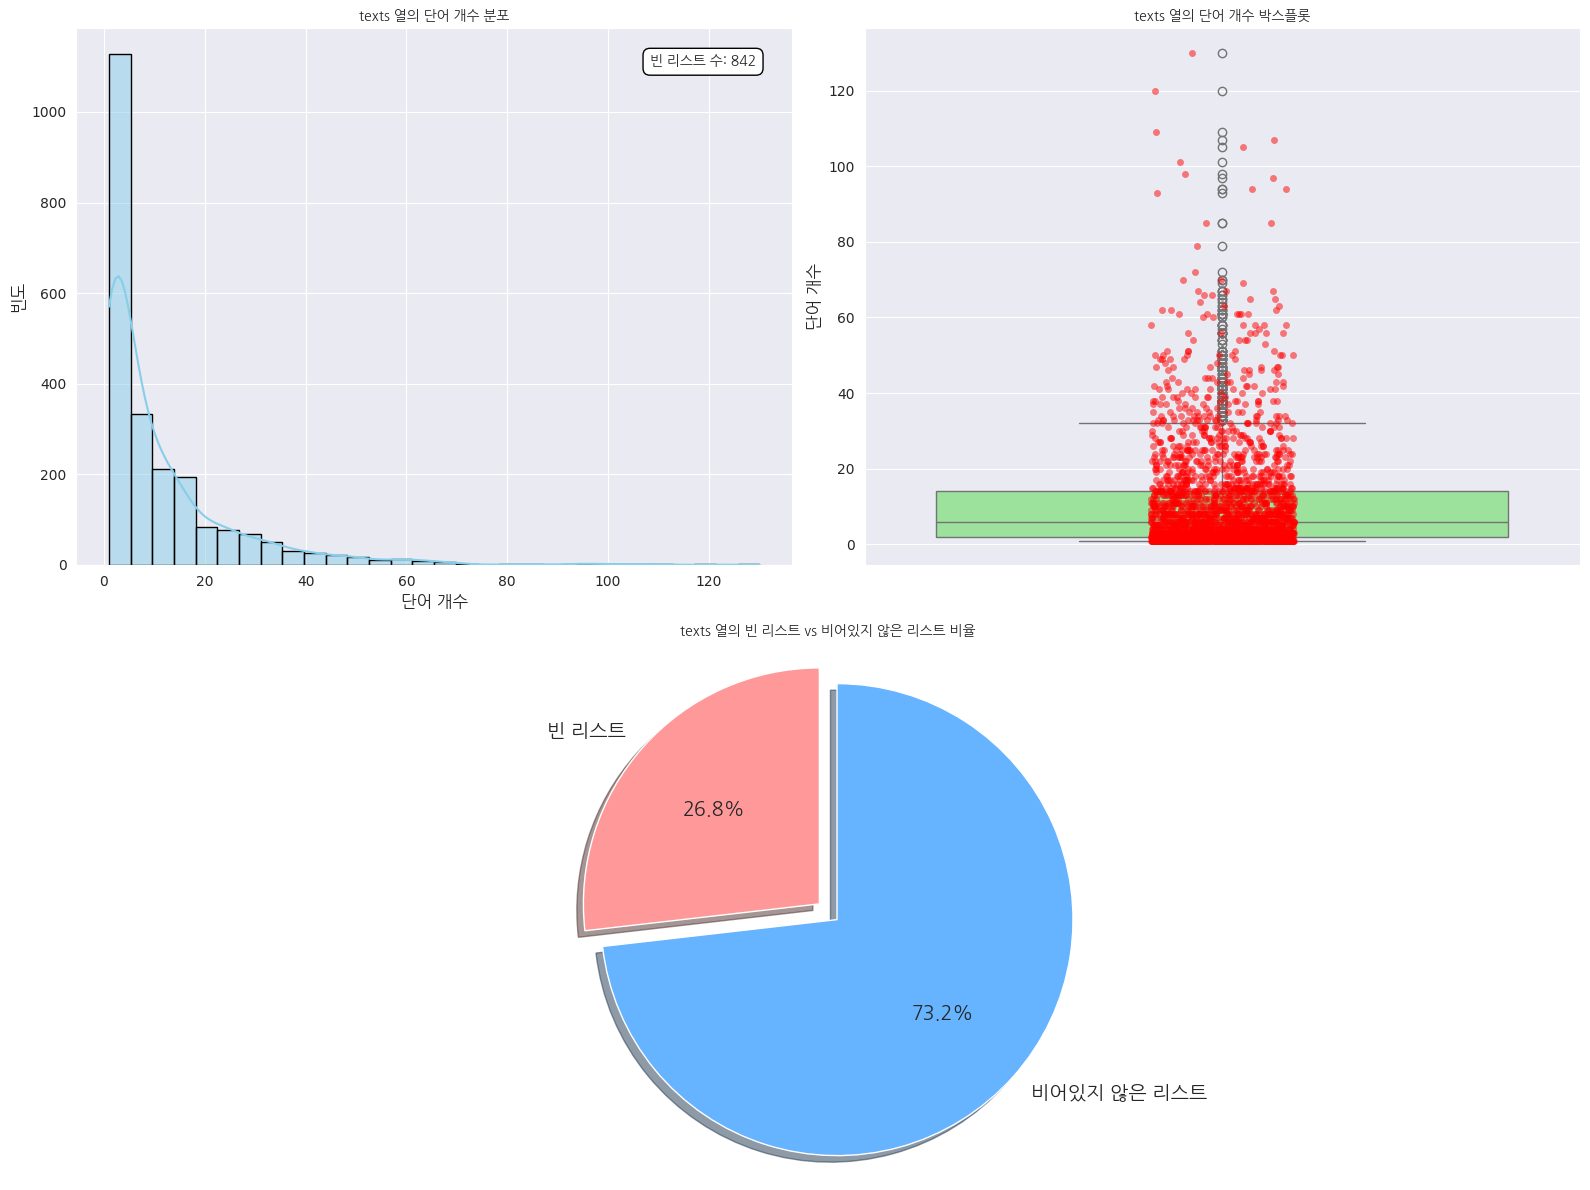


texts 열의 단어 개수 요약 통계:
count    3140.000000
mean        8.203503
std        13.366700
min         0.000000
25%         0.000000
50%         3.000000
75%        10.000000
max       130.000000
Name: texts, dtype: float64

가장 흔한 단어 개수 (상위 5개):
texts
0    842
1    429
2    282
3    194
4    138
Name: count, dtype: int64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import numpy as np
import warnings
import matplotlib.font_manager as fm

# 경고 무시 설정
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (경로를 실제 폰트 파일 위치로 변경하세요)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# CSV 파일을 DataFrame으로 불러오기
df = pd.read_csv("corrected_test_texts.csv", encoding='utf-8-sig')

# texts 열을 리스트로 변환
df['texts'] = df['texts'].apply(ast.literal_eval)

# 빈 리스트 개수 계산
empty_texts = (df['texts'].apply(len) == 0).sum()
total_rows = len(df)
empty_percentage = (empty_texts / total_rows) * 100

print(f"빈 texts 리스트 비율: {empty_percentage:.2f}%")

# 단어 개수 분포 계산
word_counts = df['texts'].apply(len)

# 그래프 스타일 설정
sns.set_style("darkgrid")
plt.figure(figsize=(16, 12))

# 단어 개수 히스토그램
plt.subplot(2, 2, 1)
sns.histplot(word_counts[word_counts > 0], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('texts 열의 단어 개수 분포', fontsize=16, fontproperties=font_prop)
plt.xlabel('단어 개수', fontsize=12, fontproperties=font_prop)
plt.ylabel('빈도', fontsize=12, fontproperties=font_prop)
plt.text(0.95, 0.95, f'빈 리스트 수: {empty_texts}', 
         transform=plt.gca().transAxes, ha='right', va='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         fontproperties=font_prop)

# 단어 개수 박스플롯
plt.subplot(2, 2, 2)
sns.boxplot(y=word_counts[word_counts > 0], color='lightgreen')
sns.stripplot(y=word_counts[word_counts > 0], color='red', alpha=0.5)
plt.title('texts 열의 단어 개수 박스플롯', fontsize=16, fontproperties=font_prop)
plt.ylabel('단어 개수', fontsize=12, fontproperties=font_prop)

# 파이 차트로 빈 리스트와 비어있지 않은 리스트의 비율 표시
plt.subplot(2, 2, (3, 4))
sizes = [empty_texts, total_rows - empty_texts]
labels = ['빈 리스트', '비어있지 않은 리스트']
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, shadow=True, textprops={'fontproperties': font_prop, 'fontsize': 14})
plt.axis('equal')
plt.title('texts 열의 빈 리스트 vs 비어있지 않은 리스트 비율', fontsize=16, fontproperties=font_prop)

plt.tight_layout()
plt.show()

# 단어 개수 요약 통계
summary = word_counts.describe()
print("\ntexts 열의 단어 개수 요약 통계:")
print(summary)

# 가장 흔한 단어 개수
most_common = word_counts.value_counts().nlargest(5)
print("\n가장 흔한 단어 개수 (상위 5개):")
print(most_common)

# OCR + Swin T

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import AutoTokenizer, AutoModel
from timm import create_model
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import easyocr
from PIL import Image
from textblob import TextBlob
from functools import lru_cache
from tqdm import tqdm
import gc
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

gc.collect()
torch.cuda.empty_cache()

# os.environ['TESSDATA_PREFIX'] = '../'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # CUDA_LAUNCH_BLOCKING 설정


In [12]:
# CSV 파일에서 텍스트 데이터를 로드하는 함수
# def load_text_from_csv(csv_path):
#     df = pd.read_csv(csv_path)
#     return {row['image']: ' '.join(eval(row['texts'])) for _, row in df.iterrows()}

# T5 적용
def load_text_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return {row['image']: ' '.join([text for text in eval(row['texts']) if text != '<extra_id_0>']) for _, row in df.iterrows()}

# 멀티모달 데이터셋 클래스
class MultimodalDataset(Dataset):
    def __init__(self, df, image_dir, csv_text_data, transform=None, tokenizer=None, max_len=512):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.csv_text_data = csv_text_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = f"{self.image_dir}/{img_name}"
        
        try:
            image = Image.open(img_path).convert('L')
            
            if self.transform:
                image = self.transform(image)
            
            text = self.csv_text_data.get(img_name, "")
            
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            
            return {
                'image': image,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.df.iloc[idx, 1], dtype=torch.long) if 'target' in self.df.columns else torch.tensor(0),
                'image_id': img_name,
                'extracted_text': text
            }
        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            # 오류 발생 시 더미 데이터 반환
            return {
                'image': torch.zeros((1, 224, 224)),
                'input_ids': torch.zeros(self.max_len, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_len, dtype=torch.long),
                'labels': torch.tensor(0, dtype=torch.long),
                'image_id': img_name,
                'extracted_text': ""
            }

# 멀티모달 모델 클래스
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        self.swin_b = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0, in_chans=1)
        self.bert = AutoModel.from_pretrained('klue/bert-base')
        
        self.image_proj = nn.Linear(self.swin_b.num_features, 512)
        self.text_proj = nn.Linear(self.bert.config.hidden_size, 512)
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.1)
                        
    def to(self, device):
        super().to(device)
        self.swin_b = self.swin_b.to(device)
        self.bert = self.bert.to(device)
        return self
        
    def forward(self, image, input_ids, attention_mask):
        image_features = self.swin_b(image)
        image_features = self.image_proj(image_features)

        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0, :]
        text_features = self.text_proj(text_features)
        
        text_length = attention_mask.sum(dim=1).float() / attention_mask.shape[1]
        text_weight = text_length.unsqueeze(1)
        
        weighted_text_features = text_features * text_weight
        
        attended_features, _ = self.attention(image_features.unsqueeze(0), 
                                              weighted_text_features.unsqueeze(0), 
                                              weighted_text_features.unsqueeze(0))
        attended_features = attended_features.squeeze(0)
        
        combined_features = torch.cat((image_features, attended_features), dim=1)
        combined_features = self.dropout(combined_features)
        
        output = self.fc(combined_features)
        return output

# 학습 함수
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad(set_to_none=True)  # 메모리 사용량 최적화
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            images = batch['image'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return avg_loss, f1

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_f1 = -np.Inf

    def __call__(self, val_loss, f1_score, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, f1_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, f1_score, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, f1_score, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). '
                            f'F1 score: {f1_score:.6f}. Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        self.best_f1 = f1_score

In [13]:
if __name__ == "__main__":
    #torch.multiprocessing.set_start_method('spawn')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 데이터 경로 설정
    data_path = '../data/'
    
    # PaddleOCR로 추출한 텍스트 데이터 로드
    csv_path = './corrected_train_texts.csv'
    csv_text_data = load_text_from_csv(csv_path)

    # 데이터 로드 및 분할
    df = pd.read_csv(f"{data_path}/train_correct_labeling.csv")
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
    test_df = pd.read_csv(f"{data_path}/sample_submission.csv")

    # 토크나이저 및 변환 준비
    tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # 그레이스케일 이미지에 맞는 값 사용
    ])

    # 데이터셋 및 데이터로더 준비
    train_dataset = MultimodalDataset(train_df, f"{data_path}/train_preprocessed", csv_text_data, transform, tokenizer)
    val_dataset = MultimodalDataset(val_df, f"{data_path}/train_preprocessed", csv_text_data, transform, tokenizer)
    test_dataset = MultimodalDataset(test_df, f"{data_path}/test_preprocessed", csv_text_data, transform, tokenizer)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

    # 모델, 손실 함수, 옵티마이저 준비
    num_classes = len(df['target'].unique())
    model = MultimodalModel(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    
    # 조기 종료 설정
    early_stopping = EarlyStopping(patience=7, verbose=True, delta=0.001, path='best_mm_t5_model.pth')

    num_epochs = 100
    best_f1 = 0
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
        
        scheduler.step()  # 학습률 조정
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}")
        
        #조기 종료 체크 (validation 에러 기준)
        early_stopping(val_loss, val_f1, model)
        if early_stopping.early_stop:
            print(f"Early stopping. Best validation loss: {early_stopping.val_loss_min:.6f}, "
                  f"Best F1 score: {early_stopping.best_f1:.6f}")
            break
        
        # 최고의 F1 스코어 업데이트 (별도로 추적)
        if val_f1 > best_f1:
            best_f1 = val_f1
            print(f"New best F1 score: {best_f1:.4f}")

    # 모델 저장
    model.load_state_dict(torch.load("best_mm_t5_model.pth"))
    model.eval()

    print("Training completed.")

Using device: cuda


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


Epoch 1/100
Train Loss: 2.0358
Val Loss: 0.9436, Val F1 Score: 0.7731
Validation loss decreased (inf --> 0.943581). F1 score: 0.773127. Saving model ...
New best F1 score: 0.7731


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Epoch 2/100
Train Loss: 0.6406
Val Loss: 0.3300, Val F1 Score: 0.8650
Validation loss decreased (0.943581 --> 0.329982). F1 score: 0.864974. Saving model ...
New best F1 score: 0.8650


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Epoch 3/100
Train Loss: 0.2790
Val Loss: 0.2153, Val F1 Score: 0.8798
Validation loss decreased (0.329982 --> 0.215343). F1 score: 0.879835. Saving model ...
New best F1 score: 0.8798


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Epoch 4/100
Train Loss: 0.1885
Val Loss: 0.2507, Val F1 Score: 0.8969
EarlyStopping counter: 1 out of 7
New best F1 score: 0.8969


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Epoch 5/100
Train Loss: 0.1362
Val Loss: 0.1758, Val F1 Score: 0.9036
Validation loss decreased (0.215343 --> 0.175798). F1 score: 0.903602. Saving model ...
New best F1 score: 0.9036


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Epoch 6/100
Train Loss: 0.1009
Val Loss: 0.1906, Val F1 Score: 0.9119
EarlyStopping counter: 1 out of 7
New best F1 score: 0.9119


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Epoch 7/100
Train Loss: 0.0655
Val Loss: 0.1614, Val F1 Score: 0.9314
Validation loss decreased (0.175798 --> 0.161446). F1 score: 0.931411. Saving model ...
New best F1 score: 0.9314


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Epoch 8/100
Train Loss: 0.0531
Val Loss: 0.1556, Val F1 Score: 0.9334
Validation loss decreased (0.161446 --> 0.155573). F1 score: 0.933388. Saving model ...
New best F1 score: 0.9334


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Epoch 9/100
Train Loss: 0.0472
Val Loss: 0.1377, Val F1 Score: 0.9452
Validation loss decreased (0.155573 --> 0.137714). F1 score: 0.945211. Saving model ...
New best F1 score: 0.9452


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Epoch 10/100
Train Loss: 0.0229
Val Loss: 0.1331, Val F1 Score: 0.9585
Validation loss decreased (0.137714 --> 0.133070). F1 score: 0.958516. Saving model ...
New best F1 score: 0.9585


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Epoch 11/100
Train Loss: 0.0123
Val Loss: 0.1398, Val F1 Score: 0.9584
EarlyStopping counter: 1 out of 7


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Epoch 12/100
Train Loss: 0.0118
Val Loss: 0.1441, Val F1 Score: 0.9613
EarlyStopping counter: 2 out of 7
New best F1 score: 0.9613


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Epoch 13/100
Train Loss: 0.0107
Val Loss: 0.1593, Val F1 Score: 0.9451
EarlyStopping counter: 3 out of 7


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Epoch 14/100
Train Loss: 0.0104
Val Loss: 0.1612, Val F1 Score: 0.9524
EarlyStopping counter: 4 out of 7


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Epoch 15/100
Train Loss: 0.0067
Val Loss: 0.1553, Val F1 Score: 0.9483
EarlyStopping counter: 5 out of 7


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Epoch 16/100
Train Loss: 0.0060
Val Loss: 0.1590, Val F1 Score: 0.9543
EarlyStopping counter: 6 out of 7


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Epoch 17/100
Train Loss: 0.0059
Val Loss: 0.1558, Val F1 Score: 0.9551
EarlyStopping counter: 7 out of 7
Early stopping. Best validation loss: 0.133070, Best F1 score: 0.958516
Training completed.


In [16]:
# PaddleOCR로 추출한 테스트 데이터의 텍스트 데이터 로드
#csv_path = './test_texts.csv'
csv_path = './corrected_test_texts.csv'
csv_text_data = load_text_from_csv(csv_path)

# 테스트 데이터 로드
test_df = pd.read_csv(f"{data_path}/sample_submission.csv")

# 토크나이저 및 변환 준비
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # 그레이스케일 이미지에 맞는 값 사용
])

# 테스트 데이터셋 및 데이터로더 준비
test_dataset = MultimodalDataset(test_df, f"{data_path}/test_preprocessed", csv_text_data, transform, tokenizer)

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

# 모델 준비
num_classes = len(pd.read_csv(f"{data_path}/train_correct_labeling.csv")['target'].unique())
model = MultimodalModel(num_classes).to(device)

# 저장된 모델 불러오기
model.load_state_dict(torch.load("best_mm_model.pth"))
model.eval()

print("Model loaded. Starting test data prediction...")

# 테스트 데이터 추론
test_predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting test data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())

# 결과 저장
submission_df = pd.DataFrame({'ID': test_df['ID'], 'target': test_predictions})
submission_df.to_csv("multimodal_pred.csv", index=False)
print("Test predictions saved to multimodal_pred.csv")

Model loaded. Starting test data prediction...


Predicting test data: 100%|██████████| 99/99 [00:30<00:00,  3.20it/s]

Test predictions saved to multimodal_pred.csv
